# MST with networkx

In [37]:
import numpy as np
import pandas as pd
import pylab as plt
from Bio import AlignIO
from snipgenie import tools, plotting

In [31]:
def check_keys(d, vals):
    """Remove dict keys not in vals"""

    new = d.copy()
    keys = list(d.keys())
    for key in keys:
        if not key in vals:
            new.pop(key, None)
    return new

def make_legend(fig, colormap, loc=(1.05, .6), title='',fontsize=12):
    """Make a figure legend wth provided color mapping"""

    import matplotlib.patches as mpatches
    pts=[]
    for c in colormap:
        pts.append(mpatches.Patch(color=colormap[c],label=c))
    fig.legend(handles=pts,bbox_to_anchor=loc,fontsize=fontsize,title=title)
    return pts

In [35]:
def dist_matrix_to_mst(distance_matrix, df=None, colorcol=None, labelcol=None, colormap=None,
                       cmap_name='Set1', node_size=4, font_size=6, with_labels=False,
                       edge_labels=False, legend_loc=(1, .7), ax=None):
    """
    Dist matrix to minimum spanning tree
    Args:
        distance_matrix: matrix as dataframe
        df: meta data with index corresponding to node names of tree
        colorcol: column in meta table to color nodes by
        labelcol: column in meta table to label nodes by
        colormap: a mapping of node names to colors
        cmap_name: name of an mpl colormap to apply instead of providing colormap
        node_size: size of nodes
        with_labels: whether to plot labels on nodes
        legend_loc: location of legend
    """

    import networkx as nx
    from networkx.drawing.nx_agraph import graphviz_layout
    if ax == None:
        fig,ax=plt.subplots()
    G = nx.Graph()

    for i, row in distance_matrix.iterrows():
        for j, weight in row.items():
            G.add_edge(i, j, weight=weight)

    T = nx.minimum_spanning_tree(G, algorithm='kruskal')
    # Compute edge lengths based on distances
    edge_lengths = [T[u][v]['weight'] for u, v in T.edges()]
    # Plot the minimum spanning tree with edge lengths proportional to distances
    pos = graphviz_layout(T)
    labels = nx.get_edge_attributes(T, 'weight')
    if df is not None:
        l = [label for label in T.nodes if label in df.index]
        df = df.loc[l]
        if colormap is None:
            colors,cmap = plotting.get_color_mapping(df, colorcol, cmap_name)
        else:
            #custom colormap if provided
            colors = [colormap[i] if i in colormap else 'black' for i in df[colorcol]]
            cmap = colormap
        #print (cmap)
        C = dict(zip(df.index, colors))
        node_colors = [C[node] if node in C else 'Black' for node in T.nodes()]
        #checks that colormap matches nodes so legend doesn't have crap in it
        cmap = check_keys(cmap, df[colorcol].unique())
        #add legend for node colors
        p = make_legend(ax.figure, cmap, loc=legend_loc, title=colorcol,fontsize=9)

    else:
        node_colors = 'black'
    nx.draw_networkx(T, pos, node_color=node_colors, node_size=node_size,
                     font_size=font_size, with_labels=with_labels, ax=ax)
    if edge_labels == True:
        nx.draw_networkx_edge_labels(T, pos, edge_labels=labels, font_size=font_size*.7, ax=ax)

    if labelcol not in [None,'']:
        node_labels = {node:df.loc[node][labelcol] if node in df.index else '' for node in T.nodes()}
        #print (node_labels)
        nx.draw_networkx_labels(T, pos, labels=node_labels, font_size=font_size,
                 horizontalalignment='right',verticalalignment='top')
    ax.axis('off')
    return T, pos

In [152]:
def generate_distance_matrix(n):
    from scipy.spatial import distance_matrix

    # Generate random coordinates in a latent space
    coordinates = np.random.rand(n, 4)    
    # Compute the pairwise distances between the coordinates
    dist_matrix = distance_matrix(coordinates, coordinates)    
    # Create row and column labels
    labels = [f"item{i+1}" for i in range(n)]    
    # Convert the matrix to a pandas DataFrame
    distance_df = (pd.DataFrame(dist_matrix, index=labels, columns=labels)*10).round(1)
    return distance_df


In [153]:
def generate_random_metadata(names):
    import random
    # Define possible values for the metadata fields
    countries = ['Ireland', 'UK', 'USA', 'Canada', 'Australia']
    codes = ['A', 'B', 'C', 'D', 'E']
    years = list(range(2000, 2025))    
    # List to store metadata for each name
    metadata = []    
    for name in names:
        # Randomly select values for the metadata fields
        country = random.choice(countries)
        code = random.choice(codes)
        year = random.choice(years)        
        # Append the metadata as a dictionary
        metadata.append({
            'name': name,
            'country': country,
            'code': code,
            'year': year
        })    
    # Convert the list of metadata dictionaries to a pandas DataFrame
    metadata_df = pd.DataFrame(metadata).set_index('name')
    return metadata_df

In [171]:
dm = generate_distance_matrix(20)
meta = generate_random_metadata(dm.index)

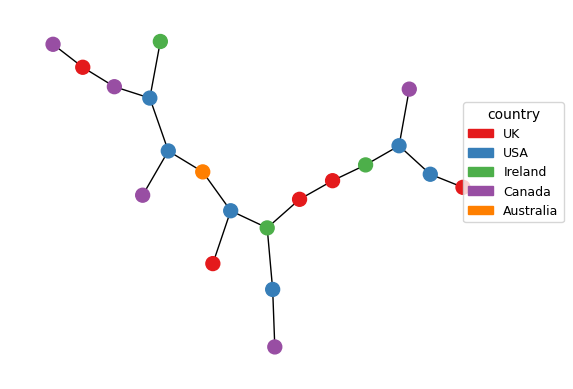

In [172]:
T,pos=dist_matrix_to_mst(dm, meta, 'country', node_size=100)

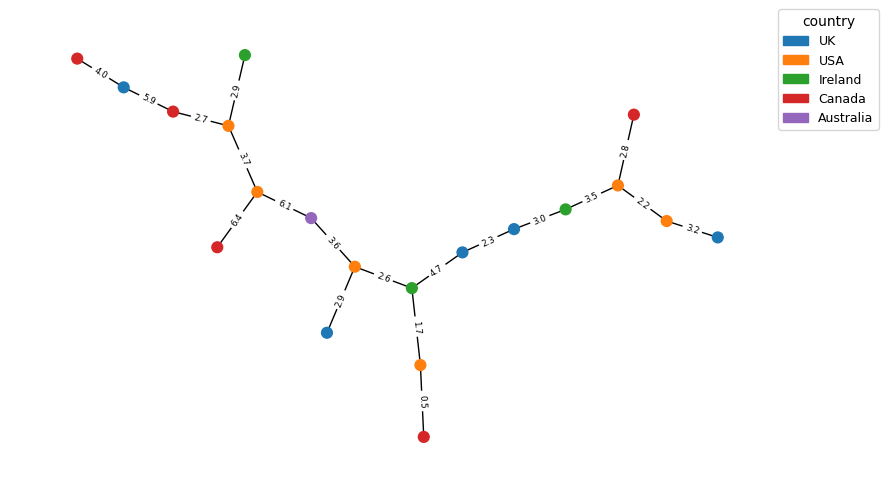

In [173]:
fig,ax=plt.subplots(1,1,figsize=(10,6))
T,pos = dist_matrix_to_mst(dm,meta,colorcol='country',cmap_name='tab10',edge_labels=True,font_size=9,
                                 node_size=60,legend_loc=(1,.9),ax=ax)

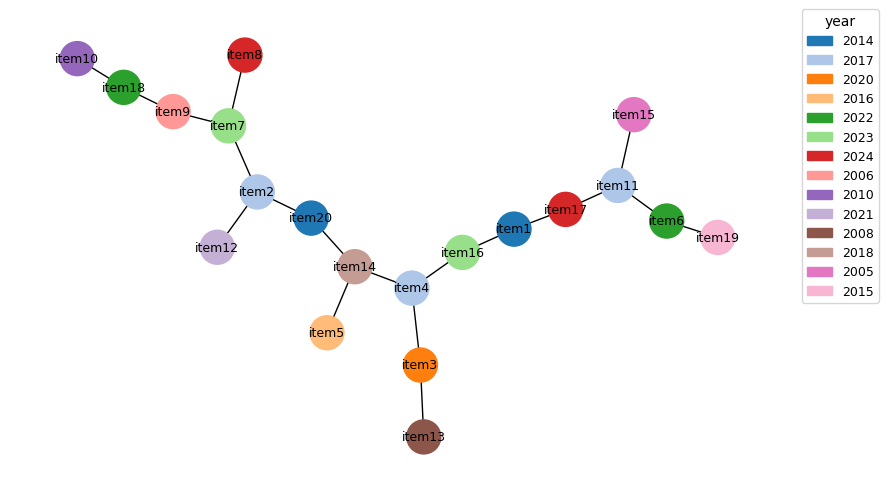

In [174]:
fig,ax=plt.subplots(1,1,figsize=(10,6))
T,pos = dist_matrix_to_mst(dm,meta,colorcol='year',cmap_name='tab20',with_labels=True,font_size=9,
                                 node_size=600,legend_loc=(1,.9),ax=ax)

In [175]:
def dm_cluster(distance_matrix, t, linkage='average'):
    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(distance_threshold=t, n_clusters=None,
                                         linkage=linkage, metric='precomputed').fit(distance_matrix)
    labels = clustering.labels_+1
    clusters = pd.DataFrame(labels,columns=['cluster'],index=distance_matrix.index)    
    return labels, clusters

In [178]:
dm = generate_distance_matrix(200)
meta = generate_random_metadata(dm.index)

In [179]:
labels,cl = dm_cluster(dm, 7)
meta['cluster'] = labels

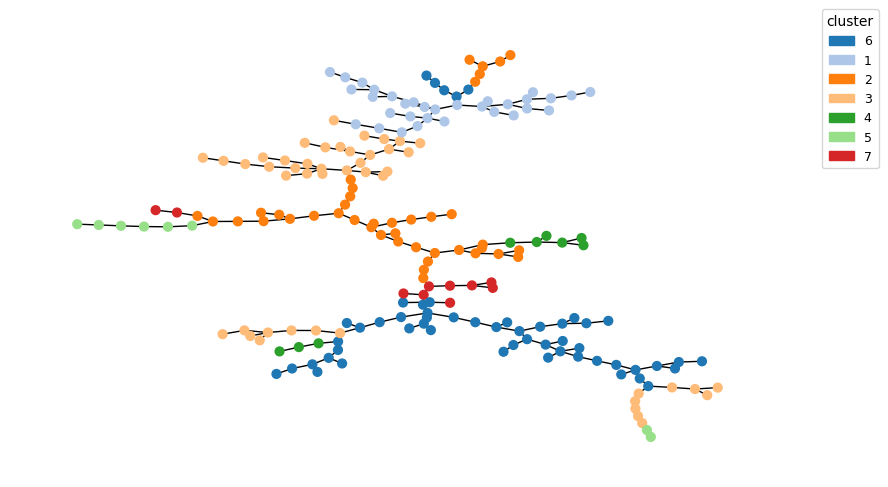

In [184]:
fig,ax=plt.subplots(1,1,figsize=(10,6))
T,pos = dist_matrix_to_mst(dm,meta,colorcol='cluster',cmap_name='tab20',font_size=9,
                                 node_size=40,legend_loc=(1,.9),ax=ax)